Dans ce premier code nous utilisons la méthode CaseBasedExplainer sur le dataset MNIST avec l'utilisation d'une méthode de calcul de poids qui est Occlusion et une metric de distance qui est euclidean.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
Train = False

Préparation du dataset et des données qui vont être utilisé dans notre méthode

In [3]:
(ds_test, ds_val, ds_train), ds_info = tfds.load(
    'mnist',
    split=['train[:10%]','train[10%:25%]','train[25%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img)
ds_test = ds_test.map(
    normalize_img)
ds_val = ds_val.map(
    normalize_img)

In [4]:
images_tr = [elem[0] for elem in ds_train.as_numpy_iterator()]
labels = [elem[1] for elem in ds_train.as_numpy_iterator()]
#print(len(images_tr), len(labels), images_tr[0].shape)

In [5]:
images_tr = np.stack(images_tr)
labels = np.array(labels)
print(labels.shape)

(45000,)


In [6]:
model = tf.keras.models.load_model('./modelmnist')

In [7]:
if Train == True:
    model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_val,
    )

In [8]:
image_list = [elem[0] for elem in ds_test.as_numpy_iterator()]
labels_list = [elem[1] for elem in ds_test.as_numpy_iterator()]
#print(len(image_list), len(labels_list))
image_list = np.stack(image_list)
labels_list = np.array(labels_list)
print(labels_list)

[4 1 7 ... 5 7 3]


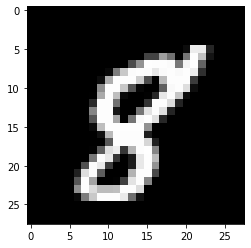

(1, 28, 28, 1)


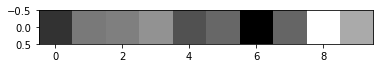

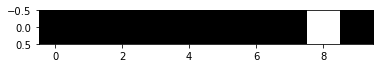

In [9]:
indice_input = 26
inputs = image_list[indice_input]
#plt.title('images que l\'on va tester')
plt.imshow(inputs, cmap='gray')
plt.show()

inputs = np.expand_dims(inputs,0)
print(inputs.shape)
targets = model.predict(inputs)
strict_targets = (targets == np.max(targets)).astype(int)
#print(targets)
plt.imshow(targets, cmap='gray')
plt.show()

plt.imshow(strict_targets, cmap='gray')
plt.show()


#print(targets)
#print(inputs.shape)

Importation de notre méthode et instanciation de cell-ci.

In [10]:
#from CaseBasedExplainer.CaseBasedExplainer import CaseBasedExplainer
from xplique.plots import plot_attributions
from xplique.attributions import Occlusion
from sklearn.neighbors import DistanceMetric
from xplique.types import Callable, Tuple, Union, Optional
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import KDTree

In [17]:
class CaseBasedExplainer():
    """
    Parameters
    ----------
    
    model
        The model from wich we want to obtain explanations
    case_dataset
        The dataset used to train the model
    batch_size
        Default = 16
    distance_function
        The function to calcul the distance between two point.
        (Can use : euclidean, manhattan, minkowski etc...)
    weights_extraction_function
        The function to calcul the weight of every features, many type of methode can be use but it will depend of
        what type of dataset you've got.
    """

    def __init__(self,
            model: Callable,
            case_dataset: Union[tf.data.Dataset, tf.Tensor, np.ndarray],
            batch_size: Optional[int] = 16,
            distance_function: DistanceMetric = None,
            weights_extraction_function: Callable = None):

        self.model = model
        self.batch_size = batch_size
        self.case_dataset = case_dataset
        self.weighted_extraction_function = weights_extraction_function
        y_pred = model.predict(case_dataset)
        #print(y_pred.shape)
        #print(case_dataset.shape)
        case_dataset_weight = self.weighted_extraction_function(case_dataset, y_pred)
        #print(case_dataset_weight.shape)
        case_dataset_weight = np.expand_dims(case_dataset_weight, 3)
        #print(case_dataset_weight.shape)
        self.case_dataset_weight = case_dataset_weight
        #case_dataset = tf.reshape(case_dataset, [-1])
        #print(case_dataset.shape)
        #print(case_dataset_weight.shape)
        weighted_case_dataset = tf.math.multiply(case_dataset_weight, case_dataset)
        weighted_case_dataset = tf.reshape(weighted_case_dataset, [weighted_case_dataset.shape[0], -1])
        print(weighted_case_dataset.shape)
        self.Knn = KDTree(weighted_case_dataset, metric = 'euclidean')
        #plot_attributions( case_dataset_weight, case_dataset, img_size=5, cmap='cividis', cols=1, alpha=0.6)

    def explain(self,
                inputs: Union[tf.Tensor, np.ndarray],
                targets: Union[tf.Tensor, np.ndarray]= None,
                k: int = 1,
                indice_original: int = None,
                labels_train: Optional[np.ndarray] = None,
                labels_test: Optional[np.ndarray] = None,
                show_result: Optional[bool]= True):
        #inputs : img, tab , ts
        #targets : [None, Tensor] (n, nb_classes)
        """
        
        Parameters
        ----------
        inputs
            Tensor or Array. Input sapmples to be explained.
            Expected shape among (N,T,W), (N,W,H,C).
        
        target
            Tensor or Array. Corresponding to the prediction of the samples by the model.
            
        K
            Represante how many nearest neighbours you want to be return.
        
        indice_original
            Represante the number of the indice of the inputs to show the true labels
        
        labels_train
            ...
            
        lables_test
            ...
        
        show_result
            Option to show or not tragets, input, and the K-nearest_neighbours.
            
        
        Returns
        -------
        
        dist
            distance between the input and the k-nearest_neighbours, represented by a float.
            
        ind 
            The index of the k-nearest_neighbours in the dataset.
        
        
        """
        # (n, H, W, D)
        weight = self.weighted_extraction_function(inputs, targets)
        #print(weight.shape)
        inputs = tf.reshape(inputs,[inputs.shape[2], -1])
        #print(inputs.shape)
        weighted_inputs = tf.math.multiply(weight, inputs)
        #print(weighted_inputs.shape)
        weighted_inputs = tf.reshape(weighted_inputs, [weighted_inputs.shape[0], -1])
        inputs = np.expand_dims(inputs,0)
        #print(inputs.shape)
        #weighted_inputs = tf.reshape(weighted_inputs, [-1])
        #weighted_inputs = np.expand_dims(weighted_inputs, 1)
        #print(weighted_inputs.shape)

        dist , ind = self.Knn.query(weighted_inputs, k = k)
        
        ind =  np.unique(ind)
        dist = np.unique(dist)
        original = tf.squeeze(inputs) 
        
        def showResult():
            explains = []
            weight_tab = []
            t_weight = tf.reshape(weight, [weight.shape[1], weight.shape[2]])
            print(t_weight.shape)
            weight_tab.append(t_weight)
            explains.append(original)
            case_dataset_weight = self.case_dataset_weight
            #case_dataset_weight = tf.reshape(case_dataset_weight, [case_dataset_weight.shape[0],case_dataset_weight.shape[1],case_dataset_weight.shape[2]])
            print(np.asarray(case_dataset_weight).shape)
            plt.rcParams["figure.autolayout"] = True
            plt.rcParams["figure.figsize"] = [20, 6]
            for i in ind:
                #case_dataset_weight[i] = tf.reshape(case_dataset_weight[i], [case_dataset_weight[i].shape[1], -1])
                #print(case_dataset_weight[i].shape)
                explains.append(self.case_dataset[i].reshape([28,28]))
                weight_tab.append(self.case_dataset_weight[i])
            for j in range(len(weight_tab)):
                #if j == 0:
                    #weight_tab[j] = tf.reshape(weight_tab[j], [-1, weight_tab[j].shape[1]])
                #else:
                if j > 0:
                    weight_tab[j] = tf.reshape(weight_tab[j], [weight_tab[j].shape[0], weight_tab[j].shape[1]])
                    #weight_tab[j] = np.expand_dims(weight_tab[j], 0)
                    #weight_tab[j] = tf.reshape(weight_tab[j], [weight_tab[j].shape[0], weight_tab[j].shape[2],weight_tab[j].shape[3]])
            #weigth_tab = tf.reshape(weight_tab, [np.asarray(weight_tab).shape[0],np.asarray(weight_tab).shape[2],np.asarray(weight_tab).shape[3] ])
            print(np.asarray(weight_tab).shape)
            print(np.asarray(explains).shape)
            fig = plt.figure()
            gs = fig.add_gridspec(2, len(explains)*2)
            for i in range(2):    
                for j in  range(len(explains)):
                    if i == 0:
                        ax = fig.add_subplot(gs[i,j])
                        plt.imshow(explains[j], cmap = 'gray')
                        plt.axis('off')
                        if j == 0:
                            pred_img = np.expand_dims(explains[j],2)
                            pred_img = np.expand_dims(pred_img,0)
                            #print(pred_img.shape)
                            pred_img = self.model.predict(pred_img)
                            pred_img = np.argmax(pred_img) # valeur des labels predit
                            #print(indice_original)
                            #print(labels_test[indice_original])
                            plt.title('Original image\nGT: '+str(labels_test[indice_original])+'\npredict: '+ str(pred_img), fontsize = 16)
                        else:
                            pred_img = np.expand_dims(explains[j],2)
                            pred_img = np.expand_dims(pred_img,0)
                            #print(pred_img.shape)
                            pred_img = self.model.predict(pred_img)
                            pred_img = np.argmax(pred_img) # valeur des labels predit
                            plt.title('K-nearest neighbours\nGT: '+str(labels_train[ind[j-1]])+'\npredict: '+ str(pred_img), fontsize = 16)
                            #print(explains[j].shape)
                    else:
                            #img = explains[j]
                            #weights = weight_tab[j]
                            #print(img.shape)
                            #print(weights.shape)
                            #weights = tf.reshape(weights, [weights.shape[1], -1])
                            #print(img.shape)
                            #print(weights.shape)
                            if j ==1:
                                weight_tab = np.asarray(weight_tab)
                                plot_attributions(weight_tab, explains, cmap='cividis', cols=1, alpha=0.6)

                '''print(labels_test[indice_original]) # valeur du label de l'image original
                pred_img = np.expand_dims(explains[j],2)
                pred_img = np.expand_dims(pred_img,0)
                #print(pred_img.shape)
                pred_img = self.model.predict(pred_img)
                pred_img = np.argmax(pred_img) # valeur des labels predit
                print(pred_img)
                print(labels_train[ind[j-1]])'''
                '''else:
                        plt.xticks([0,1,2,3,4,5,6,7,8,9])
                        plt.yticks([])
                        if j == 0:
                            
                            labl = []
                            for k in range(10):
                                if k == labels_test[indice_original]:
                                    labl.append(1)
                                else:
                                    labl.append(0)
                            labl = np.expand_dims(labl,1)
                            labl = np.expand_dims(labl,0)
                            plt.title("True label", fontsize = 16)
                            plt.imshow(labl, cmap ='gray')
                        else:
                            labl2 = []
                            
                            for k in range(10):
                                if k == labels_train[ind[j-1]]:
                                    labl2.append(1)
                                else:
                                    labl2.append(0)
                            labl2 = np.expand_dims(labl2,1)
                            labl2 = np.expand_dims(labl2,0)
                            plt.title("True label", fontsize = 16)
                            plt.imshow(labl2, cmap ='gray')   '''      
            plt.show()
            return explains
        if show_result == True:
            explaine = showResult()
        
        return dist, ind, weight

In [18]:
'''explainer = CaseBasedExplainer(model,
                               images_tr[:100],
                               distance_function = DistanceMetric.get_metric('euclidean'),
                               weights_extraction_function = lambda inputs, targets: tf.ones(images_tr[:100].shape))'''

weights_extraction_function = Occlusion(model,patch_size=(4, 4), patch_stride=(2, 2),batch_size=16, occlusion_value=0).explain
distance_function = DistanceMetric.get_metric('euclidean')

explainer = CaseBasedExplainer(model,
                               images_tr[:150],
                               distance_function = distance_function,
                               weights_extraction_function = weights_extraction_function)

C:\Users\adelin.constans\Anaconda3\envs\tfearly\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


(150, 784)


Utilisation de la partie explain de notre méthode pour la vérification de la prédiction de notre model.

(28, 28)
(150, 28, 28, 1)
(4, 28, 28)
(4, 28, 28)


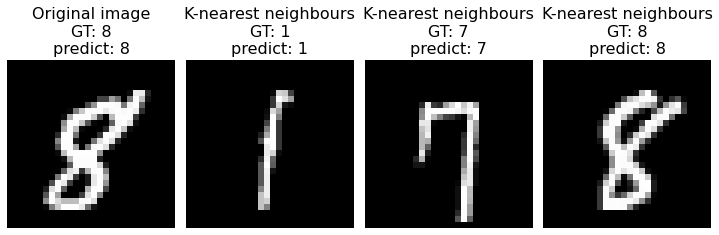

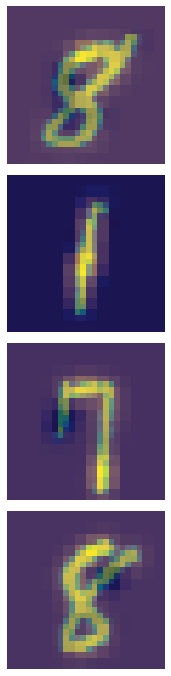

In [19]:
explanation_dist, explanation_id, weight = explainer.explain(inputs, targets,3,indice_input, labels, labels_list)
#_,_,_ = explainer.explain(inputs, strict_targets,3,indice_input, labels, labels_list)
#print(explanation_id)

In [ ]:
plot_attributions(weight, inputs, img_size=5, cmap='cividis', cols=1, alpha=0.6)